Привет!
Мы делаем проект о том, какие интересные связи и прогнозы можно вытащить из рейтинга фильмов. Для анализа взяли рейтинг https://www.imdb.com/search/title/?title_type=feature

**1 этап: парсинг**

In [4]:
!pip install requests 
!pip install beautifulsoup4`

import requests
from bs4 import BeautifulSoup

def parse_imdb_page():
    while True:
        url = yield
        response = requests.get(url=url) 
        if not response.ok: 
            return None
        
        soup = BeautifulSoup(response.text, 'html.parser') 
        all_films = soup.find_all('div', class_='lister-item mode-advanced') 
        # 'div' - тег блока, под которым у нас вся инфа о фильме. class_ - класс блока

        parsed_films_list = [] 

        for film in all_films: 
            if (film_content := film.find('div', class_='lister-item-content')) is not None: 
                film_header = film_content.find('h3', class_='lister-item-header') 
                film_name = film_header.find('a').text.strip() 
                film_url = film_header.find('a')['href'] 
                film_global_rate = film_header.find('span', class_='lister-item-index unbold text-primary').text.strip() 
                film_year = film_header.find('span', class_='lister-item-year text-muted unbold').text.strip() 
                film_rates = film_content.find('div', class_='ratings-bar') 
                
                try: # Не у всех фильмов есть отметки на meta score & imdb. Поэтому пробуем их найти
                    film_imdb_rate = film_rates.find('div', class_='inline-block ratings-imdb-rating')['data-value'] # rate по imdb
                    film_meta_score_rate = film_rates.find('div', class_='inline-block ratings-metascore').find('span').text.strip() # rate на meta score
                except:
                    film_imdb_rate = None
                    film_meta_score_rate = None

                film_muted_spans = film_content.find_all('p', class_='text-muted')

                for film_desc in film_muted_spans:
                    genre = film_desc.find('span', class_='genre')
                    duration = film_desc.find('span', class_='runtime')
                    if genre or duration:
                        film_duration = None if not duration else duration.text.strip() 
                        film_genre = genre.text.strip()
                    else:
                        film_description = film_desc.text.strip()

                try: # Не у всех фильмов есть кол-во голосов, так что пробуем их найти
                    film_votes = film_content.find('p', class_='sort-num_votes-visible').find(
                        'span', 
                        attrs={'name': 'nv'}
                    )['data-value']
                except:
                    film_votes = None

                parsed_films_list.append({
                    'name': film_name,
                    'url': film_url,
                    'global_rate': film_global_rate,
                    'release_year': film_year,
                    'imdb_rate': film_imdb_rate,
                    'metascore_rate': film_meta_score_rate,
                    'description': film_description,
                    'votes': film_votes,
                    'duration': film_duration,
                    'genre': film_genre
                }) 
            
        yield parsed_films_list


def get_result(max_count: int = 5000):
    cour = parse_imdb_page()
    next(cour)
    info = cour.send('https://www.imdb.com/search/title/?title_type=feature')
    for count in range(51, max_count, 50):
        next_url = f'https://www.imdb.com/search/title/?title_type=feature&start={count}&ref_=adv_nxt'
        next(cour)
        info += cour.send(next_url)
    else:
        cour.close()
    return info

result = get_result()
import pandas as pd

df = pd.DataFrame(result, columns=list(result[0].keys()))
df.to_csv('list.csv', index=False)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [7]:
df = df.drop('url', axis=1)
df.head()

,name,global_rate,release_year,imdb_rate,metascore_rate,description,votes,duration,genre
0,Guardians of the Galaxy Vol. 3,1.,(2023),8.3,64,"Still reeling from the loss of Gamora, Peter Q...",103132,150 min,"Action, Adventure, Comedy"
1,Evil Dead Rise,2.,(2023),6.9,69,A twisted tale of two estranged sisters whose ...,54505,96 min,Horror
2,Dungeons & Dragons: Honor Among Thieves,3.,(2023),7.4,72,A charming thief and a band of unlikely advent...,89147,134 min,"Action, Adventure, Comedy"
3,The Covenant,4.,(2023),7.6,63,"During the war in Afghanistan, a local interpr...",21043,123 min,"Action, Thriller, War"
5,A Man Called Otto,6.,(2022),7.5,51,Otto is a grump who's given up on life followi...,75159,126 min,"Comedy, Drama"


В результате парсинга собрали csv-файл с 5000 наблюдений по 10 признакам. Признаки: название фильма, год выпуска, 2 оценки и место в разных рейтингах, длительность, жанр, описание и количество голосов, отданных за этот фильм в сервисе.

**Что можно сделать с данными?**

Все качественные данные присутствуют, остуствуют оценки в некоторых наблюдениях. Оценки нельзя заменить медианой, средним или другим показателем без потери качества будущей модели, поэтому можем удалить их. Кроме того, в некоторых данных отсутсвует количество голосов за фильм и длительность продукта, но здесь оставим данные и используем для отдельного обучения.

In [8]:
df.dropna(subset=['imdb_rate', 'metascore_rate'], inplace=True)
df.head()

,name,global_rate,release_year,imdb_rate,metascore_rate,description,votes,duration,genre
0,Guardians of the Galaxy Vol. 3,1.,(2023),8.3,64,"Still reeling from the loss of Gamora, Peter Q...",103132,150 min,"Action, Adventure, Comedy"
1,Evil Dead Rise,2.,(2023),6.9,69,A twisted tale of two estranged sisters whose ...,54505,96 min,Horror
2,Dungeons & Dragons: Honor Among Thieves,3.,(2023),7.4,72,A charming thief and a band of unlikely advent...,89147,134 min,"Action, Adventure, Comedy"
3,The Covenant,4.,(2023),7.6,63,"During the war in Afghanistan, a local interpr...",21043,123 min,"Action, Thriller, War"
5,A Man Called Otto,6.,(2022),7.5,51,Otto is a grump who's given up on life followi...,75159,126 min,"Comedy, Drama"


Навели красоту в данных и оставили только полезные наблюдения.

**Дальше — исследуем данные и ищем интересные закономерности.**

Из вариантов:

1.   посмотреть, как соотносятся оценки фильма в разных рейтингах
2.   какие жанры наиболее популярны в топе
3.   как связана длительность фильма с рейтингом
4.   как жанр влияет на рейтинг фильма

это базовые варианты, можно начать с них

In [9]:
df.info

<bound method DataFrame.info of                                          name global_rate release_year  \
0              Guardians of the Galaxy Vol. 3          1.       (2023)   
1                              Evil Dead Rise          2.       (2023)   
2     Dungeons & Dragons: Honor Among Thieves          3.       (2023)   
3                                The Covenant          4.       (2023)   
5                           A Man Called Otto          6.       (2022)   
...                                       ...         ...          ...   
4994                                SLC Punk!      4,995.       (1998)   
4995            The Greatest Game Ever Played      4,996.       (2005)   
4996                               Glory Road      4,997.       (2006)   
4997                                Walkabout      4,998.       (1971)   
4999                               The Forger      5,000.       (2022)   

     imdb_rate metascore_rate  \
0          8.3             64   
1          6.

Заметим, что после чистки данных осталось 4307 наблюдений.

In [10]:
df.describe()
#информация о данных файла

,name,global_rate,release_year,imdb_rate,metascore_rate,description,votes,duration,genre
count,4307,4307,4307,4307,4307,4307,4307,4307,4307
unique,4190,4307,153,69,95,4306,4277,137,333
top,Halloween,1.,(2022),6.6,64,A kind-hearted street urchin and a power-hungr...,94485,104 min,Drama
freq,3,1,256,206,109,2,2,112,163


Text(0.5, 1.0, 'Взаимосвязь оценок фильмов в 2 разных рейтингах')

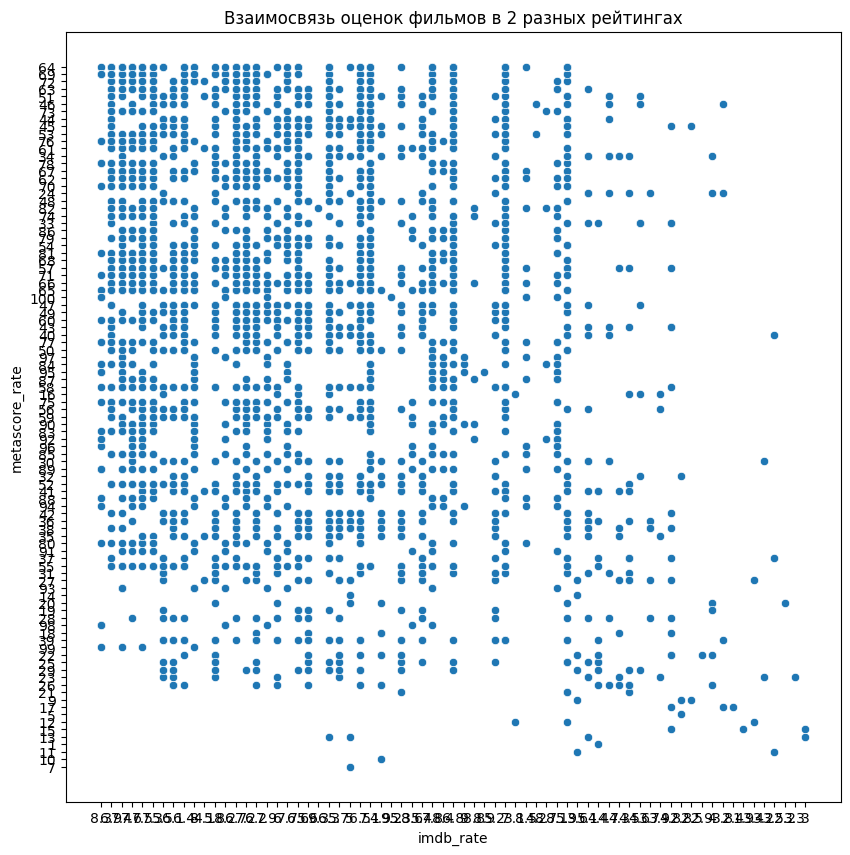

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(data=df, y='metascore_rate', x='imdb_rate', ax=ax, sizes=(10, 1000))
ax.set_title("Взаимосвязь оценок фильмов в 2 разных рейтингах")
#здесь надо шкалы пофиксить

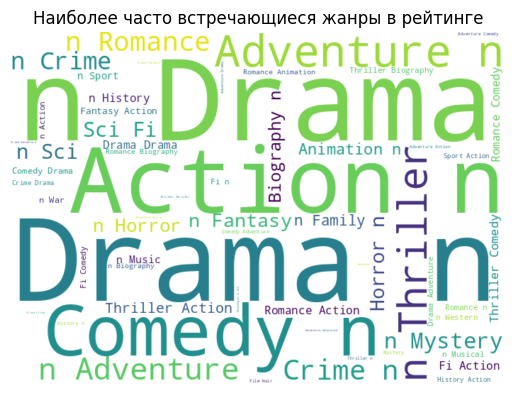

In [31]:
from wordcloud import WordCloud

text_bag = df['genre'].tolist()
for i in range(0, len(text_bag)):
    text_bag[i] = str(text_bag[i]).replace(',', '/n')
text = ' '.join(text_bag)
wordcloud = WordCloud(width=700, height=500, background_color='white')
wordcloud.generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Наиболее часто встречающиеся жанры в рейтинге');
plt.show()

Визуализации пока требуют супер доработки, так как мы сильно зависли на части с парсингом. 

Что планируем делать дальше:
1. сильно доделать часть с визуализациями: допилить облака слов, построить гистограммы и облака рассеивания
2. заняться машинным обучением. Есть несколько гипотез:
- проанализировав данные, можно предсказать оценку фильма в одном рейтинге из оценки в другом
- по оценке можно предположить жанр фильма
- возможно, по оценке и жанру можно предположить длительность фильма

по созданию новых перемнных — пока не решили, что именно будем делать.